In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hetbhalani9/movie-review-dataset-with-ratings-in-label-012")

print("Path to dataset files:", path)

100%|██████████| 813k/813k [00:00<00:00, 1.60MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/hetbhalani9/movie-review-dataset-with-ratings-in-label-012/versions/1


In [5]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample

In [6]:
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)

print(f"Loading dataset from {csv_path}...")
df = pd.read_csv(csv_path)
print(df.head())

Loading dataset from /root/.cache/kagglehub/datasets/hetbhalani9/movie-review-dataset-with-ratings-in-label-012/versions/1/sentiment_dataset.csv...
                                              review  label
0  Thunderbolts* is unlike anything we've seen be...      2
1  "Thunderbolts" it's some of Marvel's darkest m...      2
2  I went into this movie with no expectations. I...      1
3  After a string of recent disappointments, this...      2
4  For a long time I've wanted marvel to allow th...      2


In [7]:
#clean data
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['review'] = df['review'].apply(clean_text)

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])  # 0 -> Negative, 1 -> Neutral, 2 -> Positive


In [8]:
df_majority = df[df.label == 2]
df_minority_0 = df[df.label == 0]
df_minority_1 = df[df.label == 1]

df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=len(df_majority), random_state=42)
df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_0_upsampled, df_minority_1_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nClass distribution after balancing:")
print(df_balanced['label'].value_counts())


Class distribution after balancing:
label
2    1003
1    1003
0    1003
Name: count, dtype: int64


In [9]:
#tokenization
max_words = 20000
maxlen = 400

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['review'])
X = tokenizer.texts_to_sequences(df_balanced['review'])
X = pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')

# One-hot encode labels
num_classes = len(df_balanced['label'].unique())
y = to_categorical(df_balanced['label'], num_classes=num_classes)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


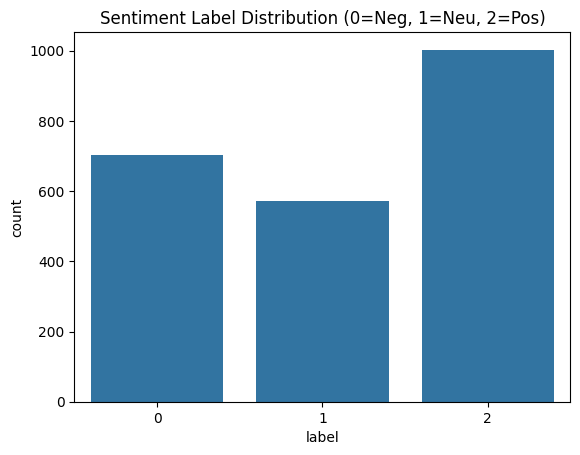

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'])
plt.title("Sentiment Label Distribution (0=Neg, 1=Neu, 2=Pos)")
plt.show()

In [11]:
#load gloVe wrod embeddings
glove_path = kagglehub.dataset_download("thanakomsn/glove6b300dtxt")
glove_file = os.path.join(glove_path, "glove.6B.300d.txt")

embedding_index = {}
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

embedding_dim = 300
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

100%|██████████| 386M/386M [00:10<00:00, 39.7MB/s]

Extracting files...


Loaded 400000 word vectors from GloVe.


In [14]:
#model build
from tensorflow.keras.regularizers import l2


model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=maxlen, trainable=True),
    Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)),
    Bidirectional(LSTM(32, dropout=0.4, recurrent_dropout=0.4)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
#model train
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.3163 - loss: 1.1714 - val_accuracy: 0.4136 - val_loss: 1.1439
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.3672 - loss: 1.1525 - val_accuracy: 0.3704 - val_loss: 1.1325
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.3668 - loss: 1.1420 - val_accuracy: 0.4086 - val_loss: 1.1132
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.4232 - loss: 1.1171 - val_accuracy: 0.4934 - val_loss: 1.0611
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.4775 - loss: 1.0535 - val_accuracy: 0.5831 - val_loss: 0.9232
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.6021 - loss: 0.9061 - val_accuracy: 0.6794 - val_loss: 0.7824
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.7138 - loss: 0.7344 - val_accuracy: 0.7159 - val_loss: 0.7415
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.7923 - loss: 0.5902 - val_accuracy: 0.7558 - v

In [16]:
#eval
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {acc:.4f}")

model.save('SentimentModel_balanced.keras')
print("Model saved as SentimentModel_balanced.keras")


Test Accuracy: 0.8223
Model saved as SentimentModel_balanced.keras


In [17]:
#pred
def predict_sentiment(review_text):
    cleaned = clean_text(review_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    pred = model.predict(padded)[0]
    label = np.argmax(pred)
    confidence = pred[label]
    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = label_map.get(label, "Unknown")
    print(f"Review: {review_text}\nPredicted Sentiment: {sentiment} ({confidence:.4f})")

In [22]:
predict_sentiment("The movie was absolutely wonderful and inspiring!")
predict_sentiment("It was a total waste of time and very boring.")
predict_sentiment("Quite a mixed feelings for this movie. Amazing stunt work but the first half of the movie really tests your patience")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Review: The movie was absolutely wonderful and inspiring!
Predicted Sentiment: Positive (0.9961)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Review: It was a total waste of time and very boring.
Predicted Sentiment: Negative (0.9395)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Review: Quite a mixed feelings for this movie. Amazing stunt work but the first half of the movie really tests your patience
Predicted Sentiment: Neutral (0.7111)


In [139]:
from google.colab import files
files.download('SentimentModel_balanced.keras')
# (and if you saved tokenizer.pkl)
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>